<a href="https://colab.research.google.com/github/Simon-delalande/Pre-training-cnn-as-autoencoder/blob/main/pretraining_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.ni.tu-berlin.de/fileadmin/fg215/teaching/nnproject/cnn_pre_trainin_paper.pdf 

This paper discuss the rise in performance that results in pre-training a CNN as a convolutional autoencoder. 
This notebook aims to try to see the difference in performance between a classical CNN and one that has been pre-trained. 

In [1]:
import numpy as np 
import tensorflow as tf 
import keras 
from keras import layers 
import matplotlib.pyplot as plt

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [3]:
train_labels, test_labels= tf.keras.utils.to_categorical(train_labels), tf.keras.utils.to_categorical(test_labels)

In [4]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 32, 32, 3)) / 255.
  return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [78]:
latent_dim= 256

In [79]:
class autoencoder(tf.keras.Model):
  def __init__(self, latent_dim):
    super(autoencoder, self).__init__()
    self.latent_dim= latent_dim 
    self.encoder= keras.Sequential(
        [
          layers.InputLayer(input_shape= (32,32,3)),
          layers.Conv2D(filters= 32, kernel_size= 3, strides= (2,2), activation ='relu'),
          layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
          layers.Dropout(0.2),
          layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          layers.Flatten(),
        ]
    )
    self.lat= keras.Sequential ([layers.Dense(latent_dim)])
    self.decoder= keras.Sequential(
        [
         layers.InputLayer(input_shape=(latent_dim,)),
         layers.Dense(units=8*8*32, activation=tf.nn.relu),
         layers.Reshape(target_shape=(8, 8, 32)),
         layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
         layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
         layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),      
        ]
    )

  def call(self, inputs):
    z= self.encoder(inputs)
    y= self.lat(z)
    out= self.decoder(y)
    return(out)

In [80]:
model= autoencoder(latent_dim)
model.compile(optimizer= 'Adam', loss= 'mean_squared_error', metrics= ['Accuracy'])
model.fit(epochs=20, x= train_images, y=train_images, validation_data= (test_images, test_images), batch_size= 32)

Epoch 1/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0204 - Accuracy: 0.5416 - val_loss: 0.0124 - val_Accuracy: 0.6497
Epoch 2/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0124 - Accuracy: 0.6605 - val_loss: 0.0102 - val_Accuracy: 0.7218
Epoch 3/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0111 - Accuracy: 0.7059 - val_loss: 0.0102 - val_Accuracy: 0.7250
Epoch 4/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0105 - Accuracy: 0.7171 - val_loss: 0.0092 - val_Accuracy: 0.7490
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0102 - Accuracy: 0.7222 - val_loss: 0.0089 - val_Accuracy: 0.7264
Epoch 6/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0100 - Accuracy: 0.7259 - val_loss: 0.0086 - val_Accuracy: 0.7430
Epoch 7/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0098 - Accuracy: 0.7278 - val_loss: 0.0085 - val_Accurac

In [81]:
model.encoder.save_weights('autoencoder')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


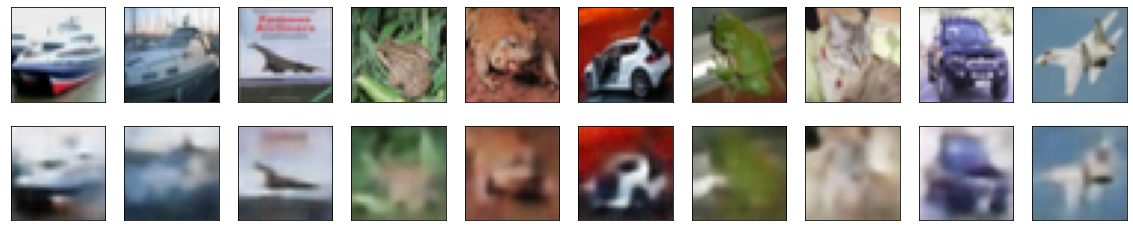

In [82]:
decoded_imgs = np.array(model(test_images))

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_images[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Data augmentation is used to avoid the overfitting that occurs quickly without it.  

In [83]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(32,
                                  32,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Convert the autoencoder to a classifier 

In [85]:
class classifier(tf.keras.Model):
  def __init__(self):
    super(classifier, self).__init__()
    self.encoder= keras.Sequential(
        [
          data_augmentation,
          layers.InputLayer(input_shape= (32,32,3)),
          layers.Conv2D(filters= 32, kernel_size= 3, strides= (2,2), activation ='relu'),
          layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
          layers.Dropout(0.2),
          layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          layers.Flatten(),
        ]
    )
    self.classifier= keras.Sequential(
        [
         layers.Dense(64, activation= 'relu'),
         layers.Dense(10, activation= 'softmax')
        ]
    )

  def call(self, input):
    z= self.encoder(input)
    y= self.classifier(z)
    return(y)


In [95]:
model2= classifier()

model2.compile(optimizer= 'Adam', loss= 'categorical_crossentropy', metrics= ['Accuracy'])
model2.encoder.load_weights('autoencoder')

assert np.array_equal(model.encoder.layers[0].get_weights()[0], model2.encoder.layers[2].get_weights()[0]) , 'weights error'

history= model2.fit(epochs=40, x= train_images, y=train_labels, validation_data= (test_images, test_labels), batch_size= 32)

Epoch 1/40
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6391 - Accuracy: 0.4098 - val_loss: 1.4800 - val_Accuracy: 0.4798
Epoch 2/40
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4335 - Accuracy: 0.4872 - val_loss: 1.3411 - val_Accuracy: 0.5261
Epoch 3/40
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3660 - Accuracy: 0.5137 - val_loss: 1.2765 - val_Accuracy: 0.5457
Epoch 4/40
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3192 - Accuracy: 0.5298 - val_loss: 1.1900 - val_Accuracy: 0.5764
Epoch 5/40
1563/1563 [==============================] - 10s 6ms/step - loss: 1.2852 - Accuracy: 0.5414 - val_loss: 1.2146 - val_Accuracy: 0.5736
Epoch 6/40
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2608 - Accuracy: 0.5532 - val_loss: 1.1723 - val_Accuracy: 0.5809
Epoch 7/40
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2384 - Accuracy: 0.5618 - val_loss: 1.1603 - val_Accuracy

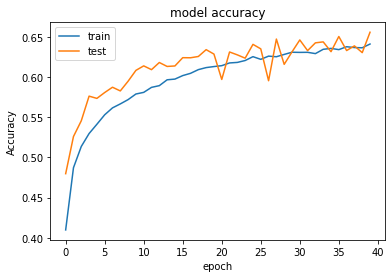

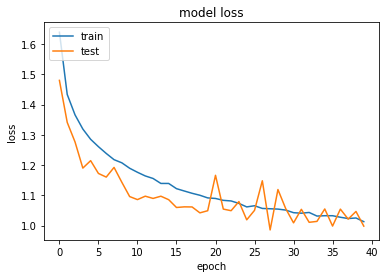

In [96]:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Now the same model but without the autoencoder pre training 


In [97]:
model3= keras.Sequential(
    [
      data_augmentation,
      layers.InputLayer(input_shape= (32,32,3)),
      layers.Conv2D(filters= 32, kernel_size= 3, strides= (2,2), activation ='relu'),
      layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
      layers.Dropout(0.2),
      layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
      layers.Flatten(),
      layers.Dense(64, activation= 'relu'),
      layers.Dense(10, activation= 'softmax')
    ]
)

model3.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_44 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 input_29 (InputLayer)       multiple                  0         
                                                                 
 conv2d_50 (Conv2D)          (None, 15, 15, 32)        896       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 7, 7, 32)          0         
                                                                 
 conv2d_51 (Conv2D)          (None, 3, 3, 64)          18496     
                                                     

In [99]:
model3.compile(optimizer= 'Adam', loss= 'categorical_crossentropy', metrics= ['Accuracy'])
history2= model3.fit( epochs=40, x= train_images, y=train_labels, validation_data= (test_images, test_labels), batch_size= 32)

Epoch 1/40
1563/1563 [==============================] - 10s 6ms/step - loss: 1.4784 - Accuracy: 0.4660 - val_loss: 1.3407 - val_Accuracy: 0.5191
Epoch 2/40
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3940 - Accuracy: 0.5008 - val_loss: 1.2340 - val_Accuracy: 0.5556
Epoch 3/40
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3425 - Accuracy: 0.5204 - val_loss: 1.1967 - val_Accuracy: 0.5691
Epoch 4/40
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3035 - Accuracy: 0.5372 - val_loss: 1.1795 - val_Accuracy: 0.5827
Epoch 5/40
1563/1563 [==============================] - 9s 6ms/step - loss: 1.2762 - Accuracy: 0.5448 - val_loss: 1.2146 - val_Accuracy: 0.5755
Epoch 6/40
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2544 - Accuracy: 0.5554 - val_loss: 1.1507 - val_Accuracy: 0.5903
Epoch 7/40
1563/1563 [==============================] - 9s 6ms/step - loss: 1.2305 - Accuracy: 0.5614 - val_loss: 1.1197 - val_Accuracy

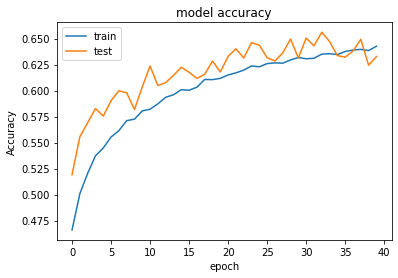

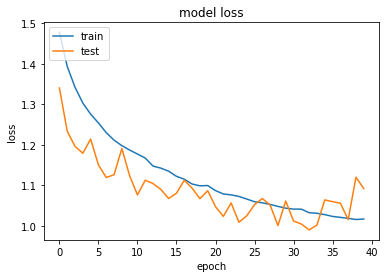

In [100]:
plt.plot(history2.history['Accuracy'])
plt.plot(history2.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()